In [1]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import scipy.stats 
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
import matplotlib.backends.backend_pdf

In [3]:
cd ..

/ihme/homes/alibow/notebooks/vivarium_research_lsff/multiplication_models


In [4]:
from mult_model_fns import *
from folic_acid.folic_acid_mult_model_fns import *

In [5]:
import getpass

In [16]:
# input_data_path = f'/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/lsff_input_coverage_data.csv'
input_data_path = f'/ihme/homes/{getpass.getuser()}/notebooks/vivarium_research_lsff/data_prep/outputs/lsff_input_coverage_data.csv'

In [6]:
## GLOBALS

In [7]:
ages = [1,2,3,4,5]
sexes = [1,2]
ages = [2,3,4,5]

draws = [f'draw_{i}' for i in range(1_000)]
index_cols=['location_id','sex_id','age_group_id']

# define alternative scenario coverage levels (low, medium, high)
    # this parameter represents the proportion of additional coverage achieved in the
    # alternative scenario, defined as the difference between the proportion of the population
    # that eats the fortified vehicle and the proportion of the population that eats 
    # the industrially produced vehicle
alternative_scenario_coverage_levels = [0.2, 0.5, 0.8]

In [8]:
rei_id = [] #folic acid doesn't effect any risks; just NTDs
cause_ids = [642] # NTDs
nonfatal_causes = [642] # YLLs and YLDs
nutrient = 'folic acid'
vehicle = 'maize flour' 

In [17]:
location_ids = pd.read_csv(input_data_path)
location_ids = location_ids[(location_ids.vehicle==vehicle)].location_id.unique().tolist()
location_ids

[179,
 214,
 190,
 189,
 196,
 201,
 180,
 202,
 205,
 171,
 184,
 168,
 141,
 207,
 181,
 213,
 522]

In [18]:
# define no fortification relative risk distribution
# folic acid specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 1.71
q_975 = 2.04

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

In [19]:
# calculate relative risk for lack of fortification
# https://vivarium-research.readthedocs.io/en/latest/concept_models/vivarium_conic_lsff/concept_model.html#effect-size-folic-acid
rr_ntds_nofort = format_rrs(lognormal_draws(mu, sigma, seed = 7), location_ids)
rr_ntds_nofort.mean(axis=1)

location_id
179    1.712028
214    1.712028
190    1.712028
189    1.712028
196    1.712028
201    1.712028
180    1.712028
202    1.712028
205    1.712028
171    1.712028
184    1.712028
168    1.712028
141    1.712028
207    1.712028
181    1.712028
213    1.712028
522    1.712028
dtype: float64

In [20]:
data = pull_coverage_data(input_data_path, nutrient, vehicle, location_ids, 'wra')

In [21]:
data = create_marginal_uncertainty(data)

In [22]:
data.head()

,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile,u5_applicable,wra_applicable
0,179,Ethiopia,NaN,maize flour,percent of population eating vehicle,na,59.263848,24.950317,93.577380,True,True
1,179,Ethiopia,NaN,maize flour,percent of population eating industrially prod...,na,27.167514,11.437632,42.897396,True,True
2,179,Ethiopia,NaN,maize flour,percent of population eating fortified vehicle,folic acid,0.000020,0.000010,0.000030,True,True
26,214,Nigeria,total population,maize flour,percent of population eating vehicle,na,57.415462,54.867114,60.033478,True,True
27,214,Nigeria,total population,maize flour,percent of population eating industrially prod...,na,8.543224,6.816199,10.339918,True,True


In [23]:
data.loc[(data.location_name=="Burkina Faso") &
     (data.value_description == "percent of population eating industrially produced vehicle"), 
     'value_mean'] = 2 * data.value_mean
# data.loc[(data.location_name=="Burkina Faso") &
#      (data.value_description == "percent of population eating industrially produced vehicle"), 
#      'value_025_percentile'] = 2 * data.value_025_percentile
data.loc[(data.location_name=="Burkina Faso") &
     (data.value_description == "percent of population eating industrially produced vehicle"), 
     'value_975_percentile'] = 2 * data.value_975_percentile

In [24]:
alpha, alpha_star = generate_coverage_tables(data, alternative_scenario_coverage_levels, seed = 11)

In [25]:
alpha.head()

,draw_0,draw_1,draw_2,draw_3,draw_4,draw_5,draw_6,draw_7,draw_8,draw_9,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
location_id,,,,,,,,,,,,,,,,,,,,,
179,1.533572e-07,9.470442e-08,1.952924e-07,2.304897e-07,1.897292e-07,1.981388e-07,8.614874e-08,1.983876e-07,2.801094e-07,2.530550e-07,...,2.809363e-07,1.576867e-07,1.037921e-07,2.615691e-07,1.768570e-07,1.883092e-07,1.400262e-07,1.616651e-07,1.616287e-07,2.241011e-07
214,8.409825e-03,9.248557e-03,1.154061e-02,1.153675e-02,6.394944e-03,2.322279e-02,1.612337e-02,1.526326e-02,1.439397e-02,1.148938e-02,...,1.164531e-02,1.184677e-02,1.223524e-02,1.714963e-02,8.164677e-03,8.650062e-03,1.323707e-02,2.178672e-02,1.431450e-02,1.219771e-02
190,7.839434e-02,4.756805e-02,6.659205e-02,7.072829e-02,4.988609e-02,5.589207e-02,5.793582e-02,7.190772e-02,8.984702e-02,2.434625e-02,...,7.570514e-02,4.963846e-02,6.292734e-02,7.943490e-02,4.984670e-02,4.252197e-02,8.746644e-02,1.011771e-01,7.810467e-02,6.852247e-02
189,2.292693e-02,1.860408e-02,3.455615e-02,3.073676e-02,1.691745e-02,1.907677e-02,2.992287e-02,2.611825e-02,2.207541e-02,2.215033e-02,...,2.654411e-02,2.761442e-02,3.630211e-02,2.538281e-02,1.962925e-02,2.231041e-02,2.986412e-02,2.903523e-02,2.933848e-02,2.520742e-02
196,5.730271e-01,6.190825e-01,7.093901e-01,5.414518e-01,6.688877e-01,6.242871e-01,5.960889e-01,5.575622e-01,6.077850e-01,6.476085e-01,...,5.100357e-01,7.009373e-01,6.142141e-01,5.487117e-01,4.312713e-01,6.087455e-01,5.445420e-01,4.832391e-01,5.292672e-01,5.546126e-01


In [26]:
alpha_star.head()

draw_0    draw_1    draw_2    draw_3    draw_4  \
location_id coverage_level                                                     
141         0.2             0.066429  0.094150  0.072019  0.041515  0.061796   
            0.5             0.166068  0.235368  0.180043  0.103784  0.154484   
            0.8             0.265707  0.376586  0.288066  0.166053  0.247173   
168         0.2             0.131305  0.099291  0.092336  0.132148  0.055049   
            0.5             0.141251  0.108547  0.101432  0.142111  0.063110   

                              draw_5    draw_6    draw_7    draw_8    draw_9  \
location_id coverage_level                                                     
141         0.2             0.039575  0.061106  0.084176  0.073901  0.014704   
            0.5             0.098934  0.152760  0.210434  0.184747  0.036758   
            0.8             0.158292  0.244415  0.336691  0.295594  0.058813   
168         0.2             0.128006  0.090572  0.093486  0.101813  0.017175   
            0.5             0.137883  0.099627  0.102609  0.111126  0.022605   

                            ...  draw_990  draw_991  draw_992  draw_993  \
location_id coverage_level  ...                                           
141         0.2             ...  0.074088  0.038511  0.069919  0.074523   
            0.5             ...  0.185215  0.096274  0.174791  0.186301   
            0.8             ...  0.296342  0.154038  0.279664  0.298079   
168         0.2             ...  0.011866  0.051403  0.052652  0.124738   
            0.5             ...  0.016342  0.059330  0.060626  0.134547   

                            draw_994  draw_995  draw_996  draw_997  draw_998  \
location_id coverage_level                                                     
141         0.2             0.066169  0.036589  0.058322  0.067294  0.089077   
            0.5             0.165417  0.091470  0.145801  0.168229  0.222685   
            0.8             0.264665  0.146351  0.233280  0.269165  0.356293   
168         0.2             0.119038  0.071082  0.078929  0.203251  0.099625   
            0.5             0.128726  0.079641  0.087697  0.214641  0.108888   

                            draw_999  
location_id coverage_level            
141         0.2             0.095621  
            0.5             0.239046  
            0.8             0.382470  
168         0.2             0.029148  
            0.5             0.035876  

[5 rows x 1000 columns]

In [27]:
gets_intervn = prop_gets_intervention_effect(location_ids, year_start=2022, estimation_years = range(2022,2026))

In [28]:
new_coverage = percolate_new_coverage(gets_intervn, alpha, alpha_star)

In [29]:
paf_ntds_nofort = paf_o_r(rr_ntds_nofort, alpha)

In [24]:
paf_ntds_nofort.mean(axis=1)

location_id
179    0.411496
214    0.408470
190    0.395386
189    0.405491
196    0.227245
201    0.411496
180    0.411496
202    0.399108
205    0.394883
171    0.411496
184    0.368241
168    0.392223
141    0.411495
207    0.401822
181    0.401686
213    0.401676
522    0.397321
dtype: float64

In [30]:
pif_ntds_nofort = pif_o_r(paf_ntds_nofort, alpha = alpha, alpha_star = new_coverage)

In [32]:
pif_ntds_nofort.mean(axis=1)

location_id  year_id  age_group_id  sex_id  coverage_level
141          2022     2             1       0.2               0.000000
                                            0.5               0.000000
                                            0.8               0.000000
                                    2       0.2               0.000000
                                            0.5               0.000000
                                                                ...   
522          2025     5             1       0.5               0.010833
                                            0.8               0.017333
                                    2       0.2               0.004092
                                            0.5               0.010229
                                            0.8               0.016366
Length: 1632, dtype: float64

In [48]:
output_pif = pif_ntds_nofort.reset_index()
output_pif = output_pif.loc[output_pif.age_group_id==2].loc[output_pif.year_id==2025]

ntd_bp = get_draws(gbd_id_type='cause_id',
                gbd_id=cause_ids,
                location_id=location_ids,
                age_group_id=164, # birth
                sex_id=sexes,
                year_id=2019,
                gbd_round_id=6,
                decomp_step='step5',
                source='como',
                measure_id=6)

ntd_bp_prepped = ntd_bp.set_index(['location_id','sex_id'])
ntd_bp_prepped = ntd_bp_prepped.drop(columns=[c for c in ntd_bp_prepped.columns if 'draw' not in c])

output_pif_prepped = output_pif.set_index(['location_id','sex_id','year_id','coverage_level']).drop(columns='age_group_id')

output_ntd_bp = ntd_bp_prepped - output_pif_prepped * ntd_bp_prepped
pop = get_population(location_id=location_ids,
                    sex_id=sexes,
                    age_group_id=164,
                    gbd_round_id=6,
                    year_id=2019,
                    decomp_step='step4').drop(columns='year_id')
output_ntd_bp = output_ntd_bp.reset_index().merge(pop, on=['location_id','sex_id'])
for i in list(range(0,1000)):
    output_ntd_bp[f'draw_{i}'] = output_ntd_bp[f'draw_{i}'] * output_ntd_bp.population
output_ntd_bp = output_ntd_bp.groupby(['location_id','year_id','coverage_level']).sum()
for i in list(range(0,1000)):
    output_ntd_bp[f'draw_{i}'] = output_ntd_bp[f'draw_{i}'] / output_ntd_bp.population * 100_000
output_ntd_bp = output_ntd_bp.drop(columns=[c for c in output_ntd_bp.columns if 'draw' not in c])

output_ntd_bp.to_pickle('results_raw/ntd_birth_prevalence_maize.pkl')

output_ntd_bp.head()

draw_0      draw_1     draw_10  \
location_id year_id coverage_level                                       
141         2025    0.2              71.883604   79.721208   82.737140   
                    0.5              68.196471   75.161362   79.692887   
                    0.8              64.509337   70.601516   76.648633   
168         2025    0.2             157.340601  171.232023  176.871711   
                    0.5             156.507163  170.588732  176.238625   

                                      draw_100    draw_101    draw_102  \
location_id year_id coverage_level                                       
141         2025    0.2              95.069105   92.143893   81.636711   
                    0.5              92.070129   88.466648   78.112511   
                    0.8              89.071154   84.789402   74.588310   
168         2025    0.2             234.769936  222.979346  194.863360   
                    0.5             234.001798  222.006956  194.071481   

                                      draw_103    draw_104    draw_105  \
location_id year_id coverage_level                                       
141         2025    0.2              92.151558   97.239514   88.206195   
                    0.5              88.747013   93.110269   84.832598   
                    0.8              85.342468   88.981025   81.459000   
168         2025    0.2             199.372474  233.364581  192.546327   
                    0.5             198.775734  233.039149  191.875654   

                                      draw_106  ...    draw_990    draw_991  \
location_id year_id coverage_level              ...                           
141         2025    0.2              78.876427  ...   85.721979   86.986550   
                    0.5              73.133564  ...   81.749244   84.986821   
                    0.8              67.390701  ...   77.776509   82.987092   
168         2025    0.2             143.509138  ...  174.824055  186.369102   
                    0.5             142.900967  ...  174.505987  185.778140   

                                      draw_992    draw_993    draw_994  \
location_id year_id coverage_level                                       
141         2025    0.2              81.835234   97.197993   79.672750   
                    0.5              77.596308   91.582740   76.597238   
                    0.8              73.357383   85.967487   73.521726   
168         2025    0.2             166.668412  218.595654  177.024657   
                    0.5             166.017568  217.457934  176.343587   

                                      draw_995    draw_996    draw_997  \
location_id year_id coverage_level                                       
141         2025    0.2              75.017070   92.284494   78.915531   
                    0.5              73.272678   88.606389   75.734427   
                    0.8              71.528286   84.928285   72.553323   
168         2025    0.2             165.421587  186.815101  159.610751   
                    0.5             164.812794  186.061728  158.843003   

                                      draw_998    draw_999  
location_id year_id coverage_level                          
141         2025    0.2              93.701256   91.858267  
                    0.5              88.761716   86.685404  
                    0.8              83.822176   81.512541  
168         2025    0.2             207.283030  214.983944  
                    0.5             206.522234  214.430477  

[5 rows x 1000 columns]

In [23]:
dalys = pull_dalys(cause_ids, cause_ids, location_ids, ages, sexes, index_cols)

In [24]:
dalys_averted = calc_dalys_averted(dalys, pif_ntds_nofort)

In [25]:
dalys_averted_u5 = dalys_averted.reset_index().groupby(['location_id','year_id','coverage_level']).sum()[draws]

In [26]:
dalys_averted_u5.head()

draw_0       draw_1       draw_2  \
location_id year_id coverage_level                                          
141         2022    0.2                0.000000     0.000000     0.000000   
                    0.5                0.000000     0.000000     0.000000   
                    0.8                0.000000     0.000000     0.000000   
            2023    0.2              462.764918   792.327297   956.344450   
                    0.5             1156.912294  1980.818242  2390.861124   

                                         draw_3      draw_4       draw_5  \
location_id year_id coverage_level                                         
141         2022    0.2                0.000000    0.000000     0.000000   
                    0.5                0.000000    0.000000     0.000000   
                    0.8                0.000000    0.000000     0.000000   
            2023    0.2              417.713646  277.849344   470.809533   
                    0.5             1044.284115  694.623361  1177.023832   

                                         draw_6       draw_7       draw_8  \
location_id year_id coverage_level                                          
141         2022    0.2                0.000000     0.000000     0.000000   
                    0.5                0.000000     0.000000     0.000000   
                    0.8                0.000000     0.000000     0.000000   
            2023    0.2              653.625431   635.808529  1149.452557   
                    0.5             1634.063579  1589.521322  2873.631394   

                                        draw_9  ...     draw_990     draw_991  \
location_id year_id coverage_level              ...                             
141         2022    0.2               0.000000  ...     0.000000     0.000000   
                    0.5               0.000000  ...     0.000000     0.000000   
                    0.8               0.000000  ...     0.000000     0.000000   
            2023    0.2             261.280462  ...   884.840589   529.579172   
                    0.5             653.201156  ...  2212.101472  1323.947930   

                                       draw_992     draw_993     draw_994  \
location_id year_id coverage_level                                          
141         2022    0.2                0.000000     0.000000     0.000000   
                    0.5                0.000000     0.000000     0.000000   
                    0.8                0.000000     0.000000     0.000000   
            2023    0.2              844.330453  1329.389691   583.621365   
                    0.5             2110.826133  3323.474227  1459.053414   

                                       draw_995     draw_996     draw_997  \
location_id year_id coverage_level                                          
141         2022    0.2                0.000000     0.000000     0.000000   
                    0.5                0.000000     0.000000     0.000000   
                    0.8                0.000000     0.000000     0.000000   
            2023    0.2              749.925585   790.465046   715.173987   
                    0.5             1874.813963  1976.162615  1787.934967   

                                       draw_998     draw_999  
location_id year_id coverage_level                            
141         2022    0.2                0.000000     0.000000  
                    0.5                0.000000     0.000000  
                    0.8                0.000000     0.000000  
            2023    0.2             1221.131607   972.358414  
                    0.5             3052.829017  2430.896036  

[5 rows x 1000 columns]

In [27]:
backup = dalys_averted_u5.copy()

In [28]:
dalys_averted_path = '/ihme/homes/beatrixh/vivarium_research_lsff/multiplication_models/folic_acid/tier1_2_3_4_5_maize_flour_dalys_averted_folic_acid_03_29_2021.csv.csv'
dalys_averted_u5.to_csv(dalys_averted_path)

In [29]:
# collapse to summary stats
dalys_averted_u5['mean_value'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].mean(axis=1)
dalys_averted_u5['p025'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.025, axis=1)
dalys_averted_u5['p975'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.975, axis=1)

dalys_averted_u5 = dalys_averted_u5[['mean_value','p025','p975']]

dalys_averted_u5 = dalys_averted_u5.reset_index()

In [30]:
dalys_averted_u5.dtypes

location_id         int64
year_id             int64
coverage_level    float64
mean_value        float64
p025              float64
p975              float64
dtype: object

In [31]:
dalys_averted_u5

,location_id,year_id,coverage_level,mean_value,p025,p975
0,141,2022,0.2,0.000000,0.000000,0.000000
1,141,2022,0.5,0.000000,0.000000,0.000000
2,141,2022,0.8,0.000000,0.000000,0.000000
3,141,2023,0.2,434.476867,89.168290,1283.891021
4,141,2023,0.5,1086.192168,222.920726,3209.727551
...,...,...,...,...,...,...
199,522,2024,0.5,5721.765603,1434.176606,14158.070923
200,522,2024,0.8,9154.824965,2294.682570,22652.913476
201,522,2025,0.2,2403.531982,603.640173,5814.931130
202,522,2025,0.5,6008.829955,1509.100431,14537.327825


In [32]:
## add rates
u5_pop = get_population(
    location_id=location_ids,
    year_id=2019,
    age_group_id=1,
    sex_id=3,
    gbd_round_id=6,
    decomp_step='step4'
)

dalys_averted_u5 = dalys_averted_u5.merge(u5_pop[['location_id','population']], on = 'location_id', how = 'left')

dalys_averted_u5['mean_dalys_per_100_000py'] = dalys_averted_u5.mean_value / dalys_averted_u5.population * 100_000
dalys_averted_u5['p025_dalys_per_100_000py'] = dalys_averted_u5.p025 / dalys_averted_u5.population * 100_000
dalys_averted_u5['p975_dalys_per_100_000py'] = dalys_averted_u5.p975 / dalys_averted_u5.population * 100_000

In [33]:
dalys_averted_u5.head()

,location_id,year_id,coverage_level,mean_value,p025,p975,population,mean_dalys_per_100_000py,p025_dalys_per_100_000py,p975_dalys_per_100_000py
0,141,2022,0.2,0.000000,0.000000,0.000000,1.082519e+07,0.000000,0.000000,0.000000
1,141,2022,0.5,0.000000,0.000000,0.000000,1.082519e+07,0.000000,0.000000,0.000000
2,141,2022,0.8,0.000000,0.000000,0.000000,1.082519e+07,0.000000,0.000000,0.000000
3,141,2023,0.2,434.476867,89.168290,1283.891021,1.082519e+07,4.013571,0.823711,11.860212
4,141,2023,0.5,1086.192168,222.920726,3209.727551,1.082519e+07,10.033928,2.059277,29.650531


In [34]:
dalys_averted_u5[(dalys_averted_u5.location_id==201)]

,location_id,year_id,coverage_level,mean_value,p025,p975,population,mean_dalys_per_100_000py,p025_dalys_per_100_000py,p975_dalys_per_100_000py
120,201,2022,0.2,0.000000,0.000000,0.000000,4.044957e+06,0.000000,0.000000,0.000000
121,201,2022,0.5,0.000000,0.000000,0.000000,4.044957e+06,0.000000,0.000000,0.000000
122,201,2022,0.8,0.000000,0.000000,0.000000,4.044957e+06,0.000000,0.000000,0.000000
123,201,2023,0.2,0.001720,0.000609,0.003628,4.044957e+06,0.000043,0.000015,0.000090
124,201,2023,0.5,0.004299,0.001522,0.009071,4.044957e+06,0.000106,0.000038,0.000224
125,201,2023,0.8,0.006879,0.002435,0.014513,4.044957e+06,0.000170,0.000060,0.000359
126,201,2024,0.2,0.002490,0.000857,0.005355,4.044957e+06,0.000062,0.000021,0.000132
127,201,2024,0.5,0.006224,0.002141,0.013387,4.044957e+06,0.000154,0.000053,0.000331
128,201,2024,0.8,0.009959,0.003426,0.021419,4.044957e+06,0.000246,0.000085,0.000530
129,201,2025,0.2,0.002631,0.000885,0.005725,4.044957e+06,0.000065,0.000022,0.000142


# viz results

In [35]:
# coverage_level_dict = {0.2:'low',0.5:'medium',0.8:'high'}
# dalys_averted_u5.coverage_level = dalys_averted_u5.coverage_level.map(coverage_level_dict)

In [36]:
{i:j for (i,j) in zip(data.location_id,data.location_name)}

{179: 'Ethiopia',
 214: 'Nigeria',
 190: 'Uganda',
 189: 'United Republic of Tanzania',
 196: 'South Africa',
 201: 'Burkina Faso',
 180: 'Kenya',
 202: 'Cameroon',
 205: "Côte d'Ivoire",
 171: 'Democratic Republic of the Congo',
 184: 'Mozambique',
 168: 'Angola',
 141: 'Egypt',
 207: 'Ghana',
 181: 'Madagascar',
 213: 'Niger',
 522: 'Sudan'}

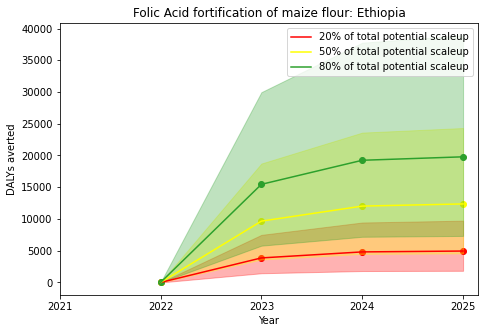

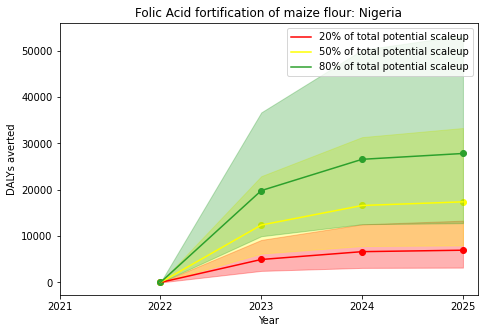

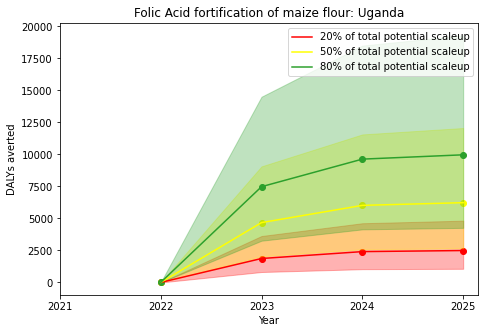

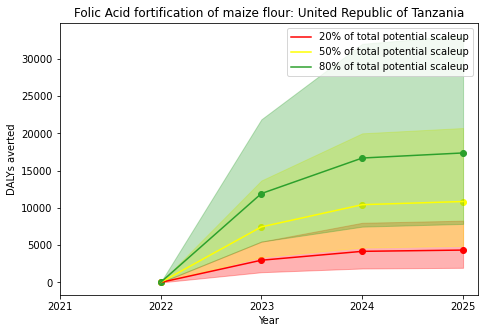

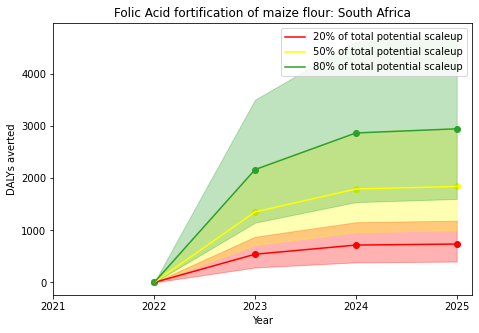

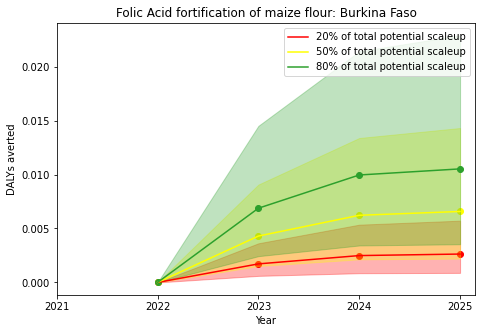

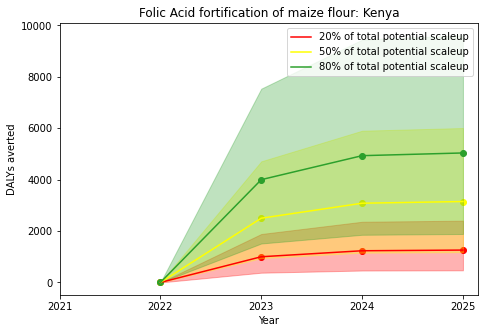

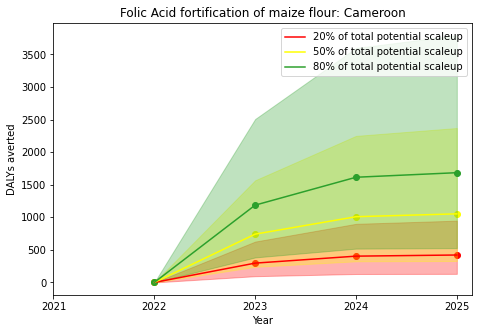

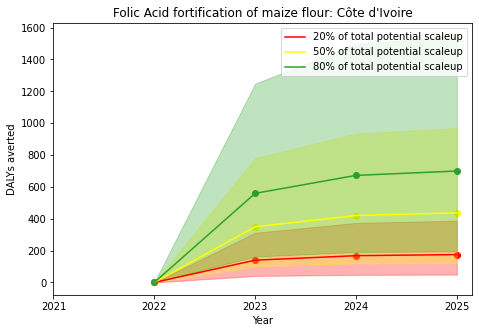

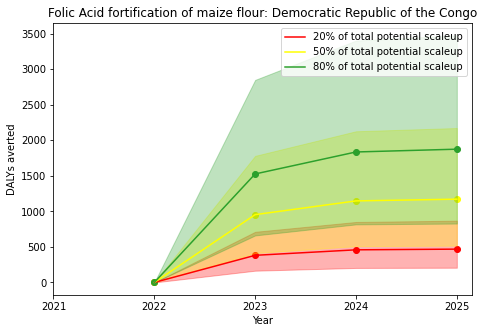

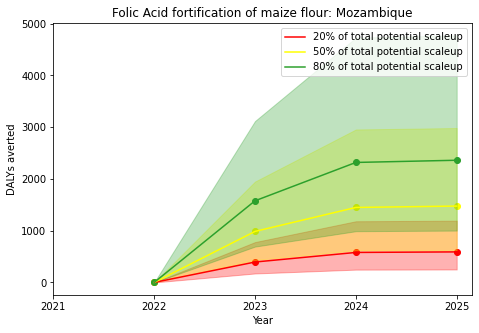

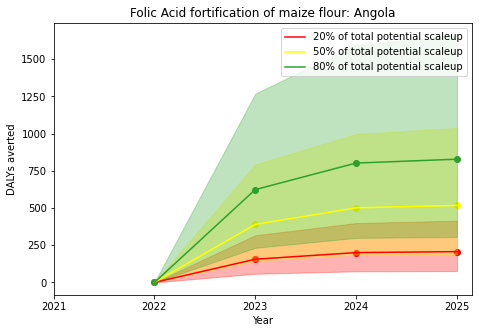

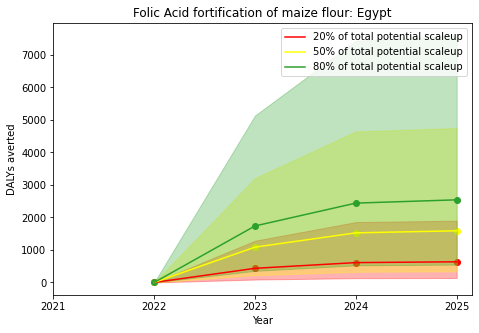

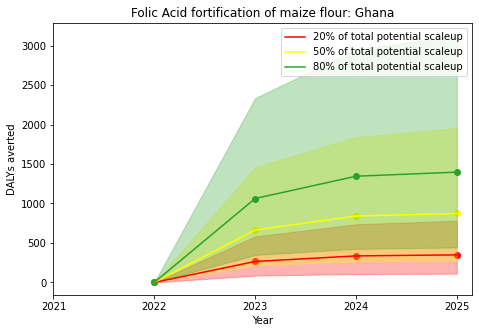

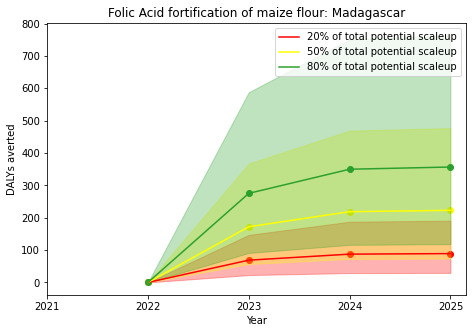

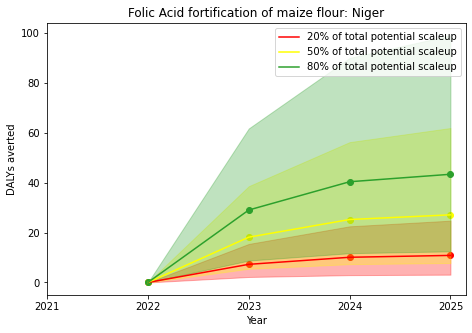

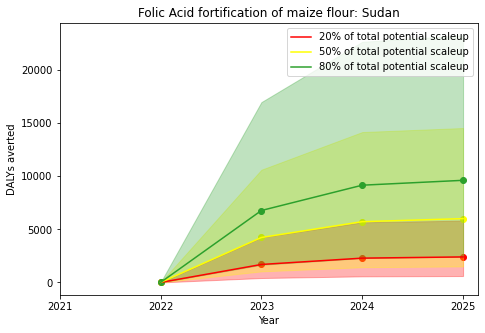

In [37]:
def plot_dalys_averted_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
    colors = {0.8: 'tab:green', 0.5:'yellow', 0.2: 'red'}
    
    for loc in location_ids: #TODO: fix/requires global 'location_ids'
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in alternative_scenario_coverage_levels:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[level], label = f'{int(level*100)}% of total potential scaleup')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification of {vehicle}: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_by_country(save_path)


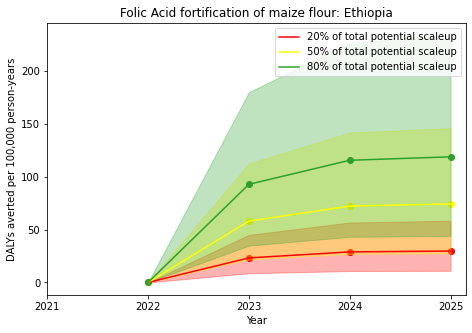

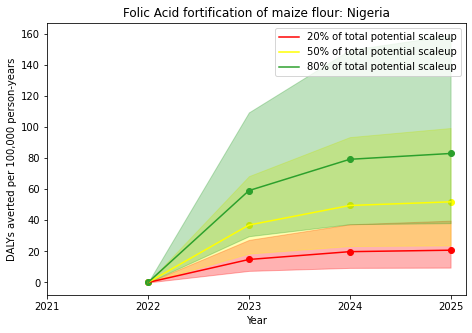

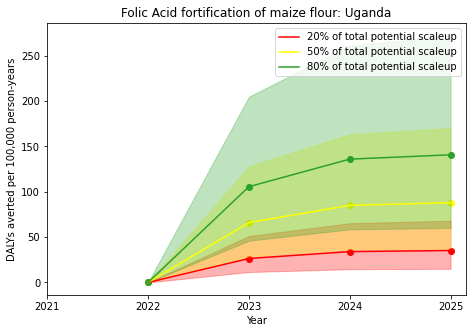

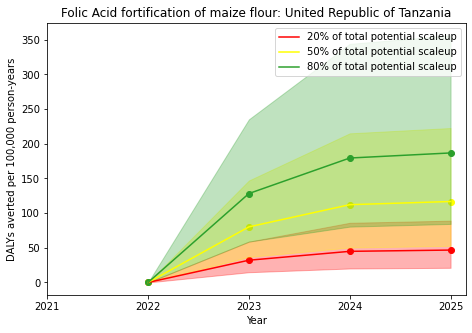

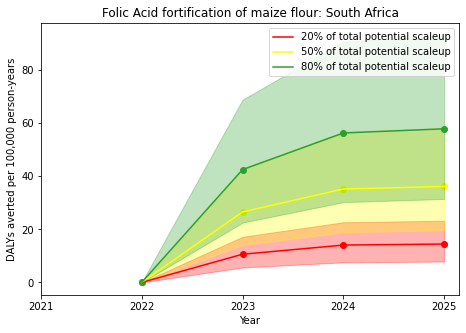

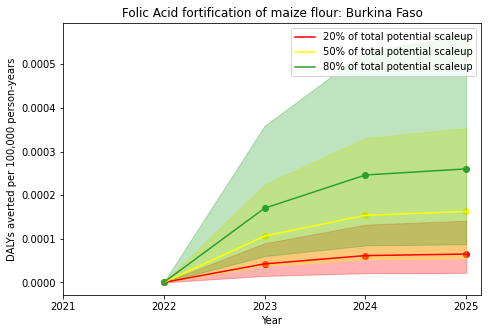

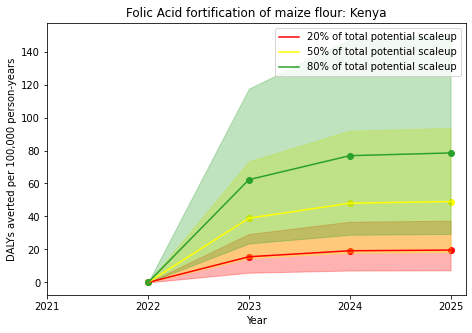

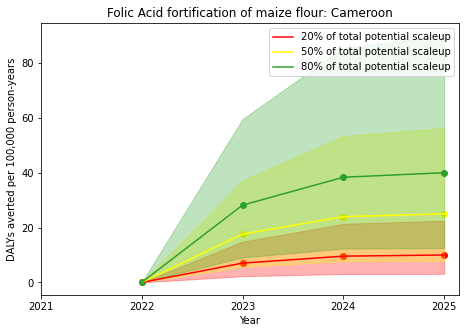

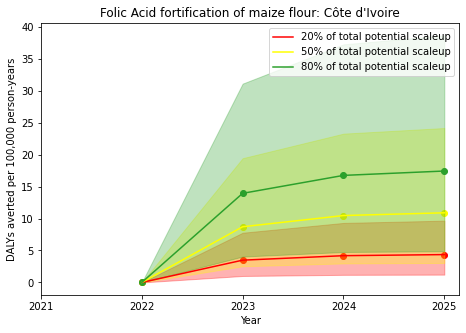

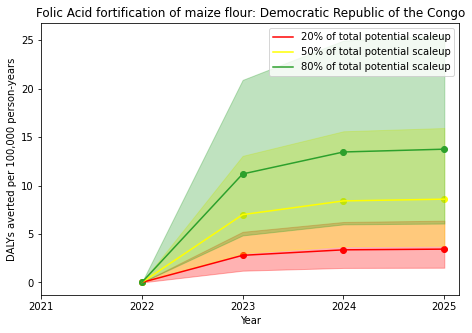

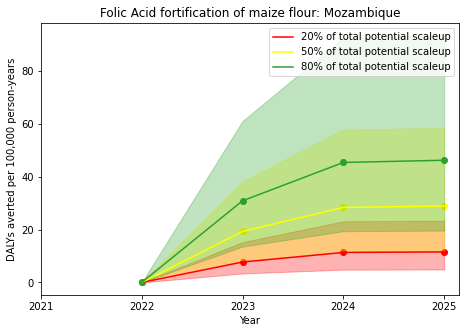

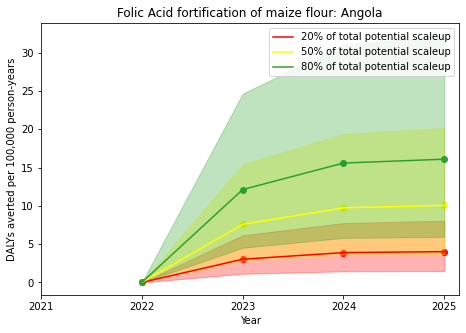

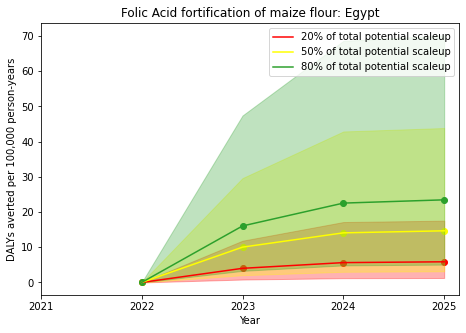

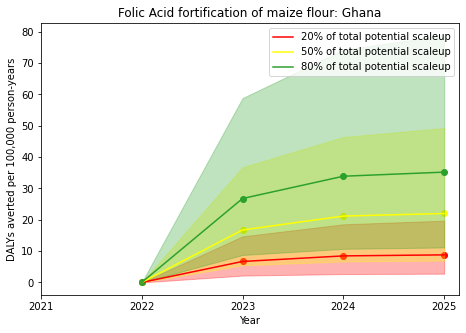

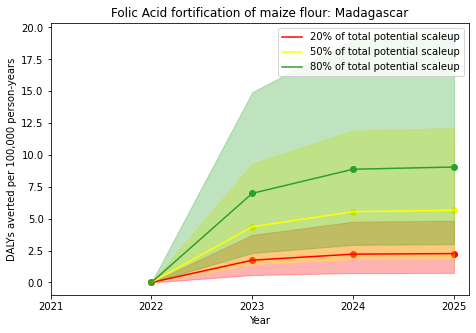

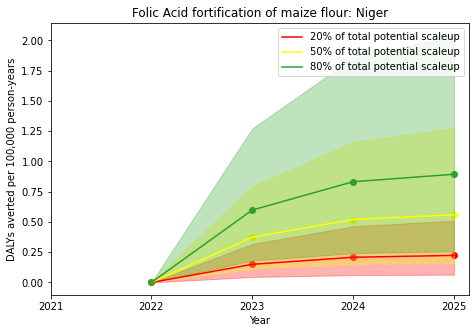

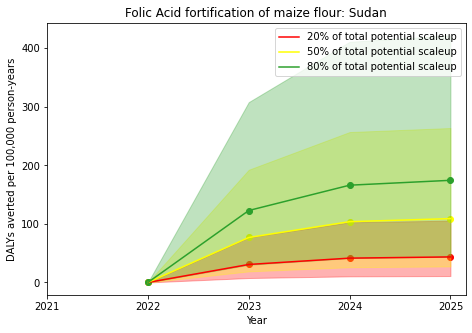

In [38]:
def plot_dalys_averted_per_100_000py_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
    colors = {0.8: 'tab:green', 0.5:'yellow', 0.2: 'red'}    
    for loc in location_ids:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in alternative_scenario_coverage_levels:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[level], label = f'{int(level*100)}% of total potential scaleup')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted per 100,000 person-years')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification of {vehicle}: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_per_100_000py_by_country(save_path)


In [39]:
# def plot_dalys_averted(save_path):
#     pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
#     location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
#     colors = ['tab:blue', 'tab:orange', 'tab:green', 'yellow', 'purple','firebrick',
#               'hotpink','steelblue','cyan','lightsalmon','greenyellow','crimson','turquoise']

#     for level in alternative_scenario_coverage_levels:
#         fig, ax = plt.subplots(figsize=(7.5, 5))
#         for i in range(len(location_ids)):
#             loc = location_ids[i]
            
#             plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                        dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[i])
#             plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                        dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[i], label = location_names[loc])
#             plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                              dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
#                              dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[i])
#             plt.ylabel('DALYs averted')
#             plt.xlabel('Year')
#             plt.title(f'Folic Acid fortification: {int(level*100)}% coverage')
#             plt.legend()
#             plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
#         pdf.savefig(fig)
    
#     plt.show()
#     pdf.close()

# save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_absolute.pdf'    
# plot_dalys_averted(save_path)


In [40]:
# def plot_dalys_averted_rate(save_path):
#     pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
#     location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
#     colors = ['tab:blue', 'tab:orange', 'tab:green', 'yellow', 'purple','firebrick',
#               'hotpink','steelblue','cyan','lightsalmon','greenyellow','crimson','turquoise']

#     for level in alternative_scenario_coverage_levels:
#         fig, ax = plt.subplots(figsize=(7.5, 5))
#         for i in range(len(location_ids)):
#             loc = location_ids[i]

#             plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                        dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[i])
#             plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                        dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[i], label = location_names[loc])
#             plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                              dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
#                              dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[i])
#             plt.ylabel('DALYs averted per 100,000 person-years')
#             plt.xlabel('Year')
#             plt.title(f'Folic Acid fortification: {int(level*100)}% coverage')
#             plt.legend()
#             plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
#         pdf.savefig(fig)

#     plt.show()
#     pdf.close()

# save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_rate.pdf'    
# plot_dalys_averted_rate(save_path)

In [41]:
# this is why kenya is negative
inputs = pd.read_csv(input_data_path)

inputs[(inputs.location_name=="Burkina Faso") & (inputs.nutrient=="folic acid")]



,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile,u5_applicable,wra_applicable
107,201,Burkina Faso,NaN,maize flour,percent of population eating fortified vehicle,folic acid,0.0000,0.000000,0.000000,True,True
117,201,Burkina Faso,NaN,wheat flour,percent of population eating fortified vehicle,folic acid,32.1645,14.137563,50.191437,True,True


In [42]:
inputs[(inputs.location_name=="Burkina Faso") & (inputs.vehicle.isin(['maize flour','wheat flour'])) & (inputs.value_description=="percent of population eating industrially produced vehicle")]

,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile,u5_applicable,wra_applicable
106,201,Burkina Faso,NaN,maize flour,percent of population eating industrially prod...,na,0.0,0.000000,0.000000,True,True
116,201,Burkina Faso,NaN,wheat flour,percent of population eating industrially prod...,na,52.3,22.987908,81.612092,True,True
